# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [59]:
from sklearn.base import ClusterMixin

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максимальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        
    def init_centroids(self, X, y=None):
        # Инициализируем начальное положение центройдов
        if self.init == 'random':
            # Случайный выбор k кластеров из набора начальных данных
            self.centroids = X[np.random.choice(X.shape[0], self.k)]
        elif self.init == 'k-means':
            # В улучшении алгоритма k-means до k-means++ применяется
            # поиск более "хороших" начальных центройдов по следующему алгоритму:
            # 1. Выбрать первый центройд случайно
            self.centroids[0] = X[np.random.choice(X.shape[0])]
            # 2. Для каждой точки из Х вычислить наименьшую меру близости 
            # (квадрат расстояния) до существующих центройдов
            def calc_measure(step):
                from sklearn.metrics import pairwise_distances
                #points_to_centroids = X[np.newaxis,:] - self.centroids[:step, np.newaxis]
                #distances = np.sum(points_to_centroids**2, axis=2) # Евклидово расстояние
                distances = pairwise_distances(X=X, Y=self.centroids[:step], metric=self.metric)
                minimal_dist = np.min(distances, axis=0)
                return minimal_dist

            # 3. Выбрать следующий центройд с вероятностью, пропорциональной полученной мере.
            # Для этого параллельно с минимумом меры вычисляем сумму расстояний. 
            # После накопления суммы вычислить rand(0,1)*sum и определить соответствующую точку 
            # в качестве центройда (повторным пробегом суммирования расстояний по точкам)
            def choose_centroid(step):
                measure = calc_measure(step)
                
                barrier = np.random.random() * np.sum(measure, axis=0)
                new_centroid = X[np.cumsum(measure, axis=0) >= barrier][0]
                self.centroids[step] = new_centroid

            # 4. Повторять 2 и 3 до достижения нужного числа центройдов.
            for step in xrange(1, self.k):
                choose_centroid(step)

            return self.centroids

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        ## Your Code Here
        self.init_centroids(X, y)
        
        # Обучение модели
        for iter in xrange(self.max_iter):
            prediction = self.predict(X, y)
            previous_centroids = self#self.labels
            # Eсли модель достаточно хорошо делает предсказания - завершение обучения.
            if np.array_equal(prediction, previous_centroids):
                break
            # Иначе - сохраним полученный ранее результат и переместим центройды в центр соответствующей группы.
            previous_centroids = prediction 
            for centr in xrange(self.centroids.shape[0]):
                points_in_group = X[previous_centroids==centr]
                if points_in_group.size > 0:
                    self.centroids[centr] = points_in_group.mean(axis=0) # среднее значение в группе
            self.labels = previous_centroids        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        points_to_centroids = X - self.centroids[:, np.newaxis]
        distances = ((points_to_centroids**2).sum(axis=2)) # Евклидово расстояние
        centroid_with_minimal_dist = np.argmin(distances, axis=0)
        return centroid_with_minimal_dist

class MiniBatchKMeans(Kmeans):
    '''The algorithm takes small batches (randomly chosen) of the dataset for each iteration. 
    It then assigns a cluster to each data point in the batch, depending on the previous locations 
    of the cluster centroids. It then updates the locations of cluster centroids based on the new 
    points from the batch.'''
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random', 
                 batch_size=100, epsilon=1e-5):
            Kmeans.__init__(self, k, metric, max_iter, random_state, init)
            self.batch_size = batch_size
            self.epsilon = epsilon
    
    def fit(self, X, y=None):
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        # Инициализируем начальные данные для центройдов
        self.init_centroids(X, y)
        
        v = np.ones(self.k)
        
        for iter in xrange(self.max_iter):
            # Выделяем на каждом шаге маленький поднабор для анализа
            minibatch = X[np.random.choice(X.shape[0], self.batch_size)]
            prediction = self.predict(X, y) 
            new_centroids = np.empty_like(self.centroids)
            
            # Смещаем каждый центройд в центр соответствующей группы
            for centr in xrange(self.centroids.shape[0]):
                centr_points = X[prediction==centr]       # Get cached center for this x
                v[centr] += centr_points.shape[0]         # Update per-center counts
                nu = 1. / v[centr]                        # Get per-center learning rate
                                                          # Take gradient step
                new_centroids[centr] = self.centroids[centr] * (1 - nu) + nu * np.mean(centr_points, axis=0) 
                
            delta = np.linalg.norm(new_centroids - self.centroids)
            self.centroids = new_centroids
            
            if delta < self.epsilon:
                break
    pass

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [47]:
from sklearn.datasets import make_blobs

In [48]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

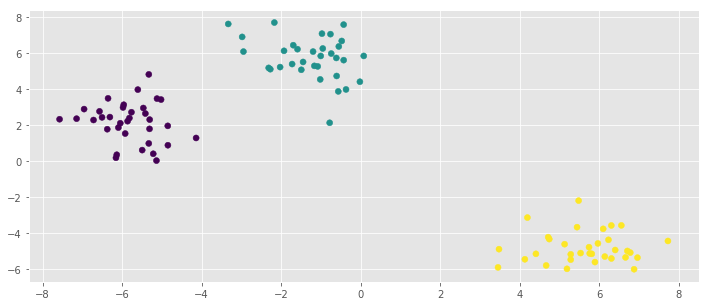

In [49]:
plt.scatter(X[:,0], X[:, 1], c=y)

In [58]:
X.shape

(100, 2)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

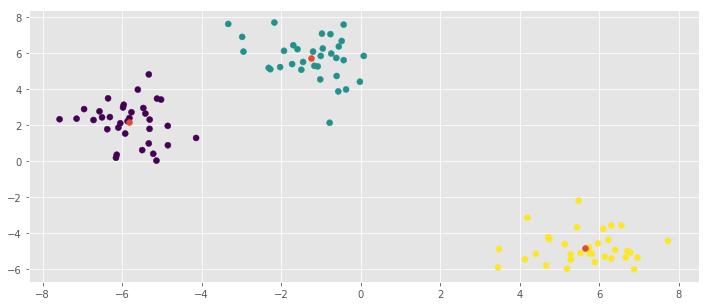

In [60]:
## Работоспособность KMeans
kmeans = Kmeans(k=3)

kmeans.fit(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1])

/home/nastya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 100 but corresponding boolean dimension is 1
/home/nastya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 100 but corresponding boolean dimension is 2


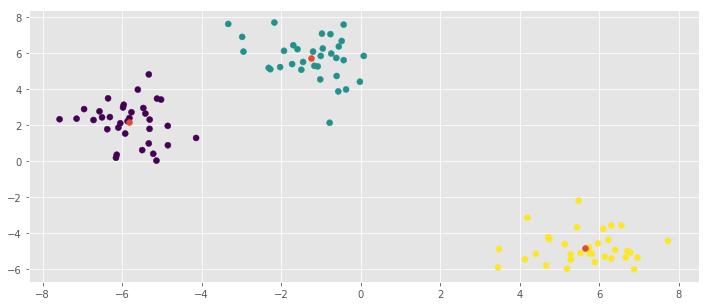

In [62]:
## Работоспособность KMeans++
kmeans = Kmeans(k=3, init='k-means')

kmeans.fit(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1])

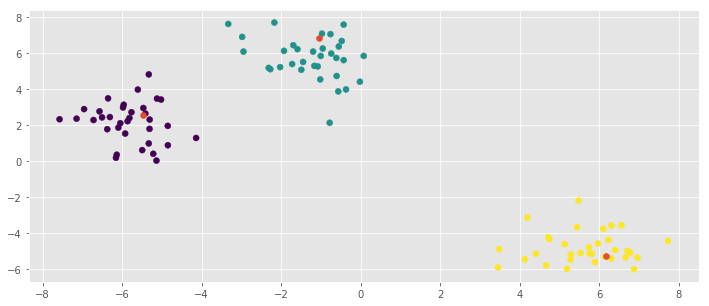

In [33]:
## Работоспособность KMeans с MiniBatchKMeans
kmeans = MiniBatchKMeans(k=3)

kmeans.fit(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1])

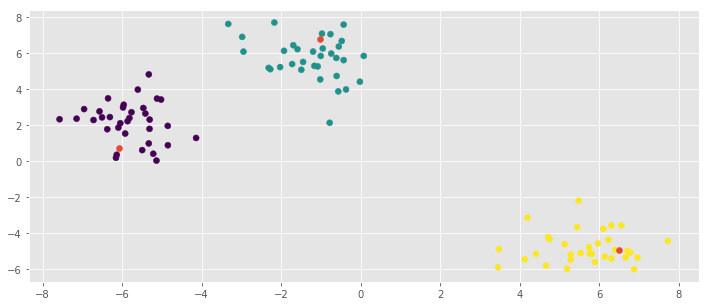

In [34]:
## Работоспособность KMeans++ с MiniBatchKMeans
kmeans = MiniBatchKMeans(k=3, init='k-means')

kmeans.fit(X)

plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(kmeans.centroids[:,0], kmeans.centroids[:,1])

1 loop, best of 3: 1.1 s per loop
1 loop, best of 3: 1.96 s per loop
1 loop, best of 3: 3.77 s per loop
1 loop, best of 3: 7.59 s per loop
1 loop, best of 3: 15.2 s per loop


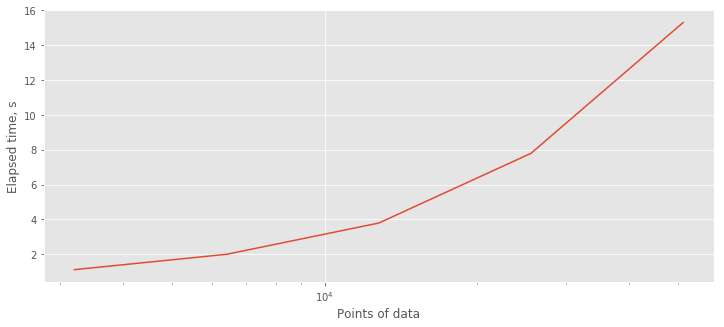

In [35]:
## Время выполнения алгоритма KMeans
iterations = 5
multiplicator = 2
results = np.empty([iterations, 2]) # Данные о результатах эксперимента [итерация, время + количество точек]
samples = 100 * 32 #Rонстанта подобрана, чтобы данные не помещались в кэш

for i in range(iterations):
    kmeans = Kmeans(k=3)
    X, y = make_blobs(n_samples=samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    d = %timeit -o kmeans.fit(X)
    results[i, 0] = np.mean(d.all_runs) / d.loops
    results[i, 1] = samples
    samples *= multiplicator

plt.ylabel('Elapsed time, s')
plt.xlabel('Points of data')
plt.semilogx(results[:,1], results[:,0])

1 loop, best of 3: 1.08 s per loop
1 loop, best of 3: 1.94 s per loop
1 loop, best of 3: 3.71 s per loop
1 loop, best of 3: 7.9 s per loop
1 loop, best of 3: 15.8 s per loop


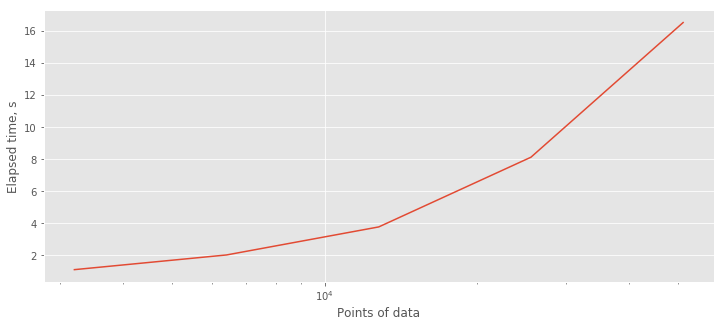

In [36]:
## Время выполнения алгоритма KMeans++
iterations = 5
multiplicator = 2
results = np.empty([iterations, 2]) # Данные о результатах эксперимента [итерация, время + количество точек]
samples = 100 * 32 #Rонстанта подобрана, чтобы данные не помещались в кэш

for i in range(iterations):
    kmeans = Kmeans(k=3, init='k-means')
    X, y = make_blobs(n_samples=samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    d = %timeit -o kmeans.fit(X)
    results[i, 0] = np.mean(d.all_runs) / d.loops
    results[i, 1] = samples
    samples *= multiplicator

plt.ylabel('Elapsed time, s')
plt.xlabel('Points of data')
plt.semilogx(results[:,1], results[:,0])

1 loop, best of 3: 304 ms per loop
1 loop, best of 3: 219 ms per loop
The slowest run took 4.37 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 233 ms per loop
1 loop, best of 3: 285 ms per loop
The slowest run took 5.59 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 205 ms per loop


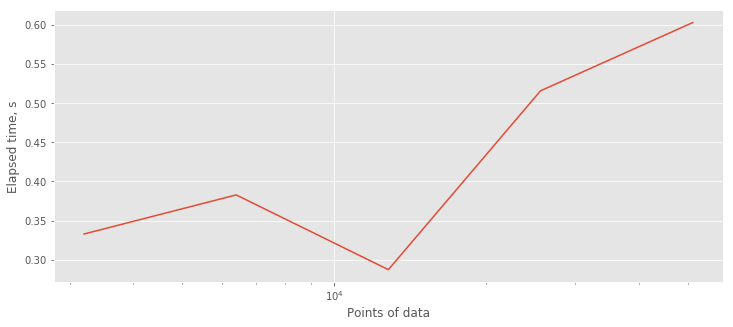

In [37]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
iterations = 5
multiplicator = 2
results = np.empty([iterations, 2]) # Данные о результатах эксперимента [итерация, время + количество точек]
samples = 100 * 32 #Rонстанта подобрана, чтобы данные не помещались в кэш

for i in range(iterations):
    kmeans = MiniBatchKMeans(k=3)
    X, y = make_blobs(n_samples=samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    d = %timeit -o kmeans.fit(X)
    results[i, 0] = np.mean(d.all_runs) / d.loops
    results[i, 1] = samples
    samples *= multiplicator

plt.ylabel('Elapsed time, s')
plt.xlabel('Points of data')
plt.semilogx(results[:,1], results[:,0])

1 loop, best of 3: 196 ms per loop
1 loop, best of 3: 94.9 ms per loop
1 loop, best of 3: 183 ms per loop
1 loop, best of 3: 178 ms per loop
10 loops, best of 3: 236 ms per loop


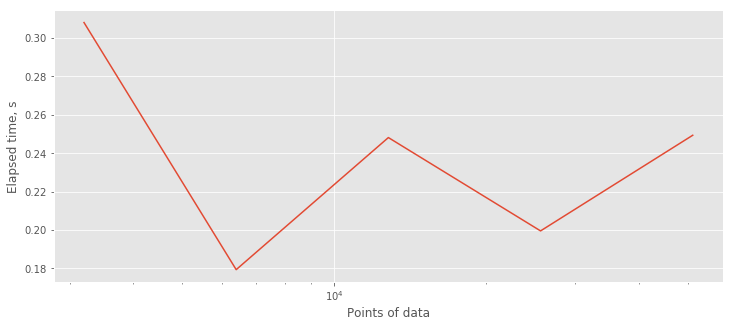

In [38]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
iterations = 5
multiplicator = 2
results = np.empty([iterations, 2]) # Данные о результатах эксперимента [итерация, время + количество точек]
samples = 100 * 32 #Rонстанта подобрана, чтобы данные не помещались в кэш

for i in range(iterations):
    kmeans = MiniBatchKMeans(k=3, init='k-means')
    X, y = make_blobs(n_samples=samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    d = %timeit -o kmeans.fit(X)
    results[i, 0] = np.mean(d.all_runs) / d.loops
    results[i, 1] = samples
    samples *= multiplicator

plt.ylabel('Elapsed time, s')
plt.xlabel('Points of data')
plt.semilogx(results[:,1], results[:,0])

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [39]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [40]:
df_sns = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], 1)
keywords = df_sns.columns

X = df_sns.iloc[:, :].values
X = X - X.mean(axis=0)
X = X / X.std(axis=0)

df_sns.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [41]:
## KMeans
kmeans = Kmeans(k=9)

kmeans.fit(X)
centroids = kmeans.centroids
for c in centroids:
    top_words = np.argsort(c)[-3:]
    print keywords[top_words]

Index([u'church', u'sports', u'tennis'], dtype='object')
Index([u'bible', u'jesus', u'blonde'], dtype='object')
Index([u'music', u'band', u'marching'], dtype='object')
Index([u'shopping', u'abercrombie', u'hollister'], dtype='object')
Index([u'basketball', u'volleyball', u'softball'], dtype='object')
Index([u'hair', u'drugs', u'kissed'], dtype='object')
Index([u'dance', u'cute', u'shopping'], dtype='object')
Index([u'soccer', u'baseball', u'football'], dtype='object')
Index([u'god', u'jesus', u'bible'], dtype='object')


In [42]:
## KMeans++
kmeans = Kmeans(k=9, init='k-means')

kmeans.fit(X)
centroids = kmeans.centroids
for c in centroids:
    top_words = np.argsort(c)[-3:]
    print keywords[top_words]

Index([u'jesus', u'tennis', u'blonde'], dtype='object')
Index([u'basketball', u'softball', u'volleyball'], dtype='object')
Index([u'hair', u'drugs', u'kissed'], dtype='object')
Index([u'shopping', u'abercrombie', u'hollister'], dtype='object')
Index([u'god', u'jesus', u'bible'], dtype='object')
Index([u'drunk', u'sex', u'blonde'], dtype='object')
Index([u'shopping', u'dance', u'dress'], dtype='object')
Index([u'basketball', u'football', u'baseball'], dtype='object')
Index([u'mall', u'cute', u'shopping'], dtype='object')


In [43]:
## KMeans с MiniBatchKMeans
kmeans = MiniBatchKMeans(k=9)

kmeans.fit(X)
centroids = kmeans.centroids
for c in centroids:
    top_words = np.argsort(c)[-3:]
    print keywords[top_words]

Index([u'dance', u'sex', u'die'], dtype='object')
Index([u'basketball', u'football', u'baseball'], dtype='object')
Index([u'god', u'die', u'clothes'], dtype='object')
Index([u'jesus', u'tennis', u'bible'], dtype='object')
Index([u'blonde', u'football', u'shopping'], dtype='object')
Index([u'hair', u'marching', u'clothes'], dtype='object')
Index([u'blonde', u'sports', u'basketball'], dtype='object')
Index([u'bible', u'blonde', u'rock'], dtype='object')
Index([u'football', u'mall', u'death'], dtype='object')


In [44]:
## KMeans++ с MiniBatchKMeans
kmeans = MiniBatchKMeans(k=9, init='k-means')

kmeans.fit(X)
centroids = kmeans.centroids
for c in centroids:
    top_words = np.argsort(c)[-3:]
    print keywords[top_words]

Index([u'rock', u'football', u'cheerleading'], dtype='object')
Index([u'sports', u'hot', u'death'], dtype='object')
Index([u'god', u'church', u'mall'], dtype='object')
Index([u'rock', u'sports', u'baseball'], dtype='object')
Index([u'football', u'mall', u'cheerleading'], dtype='object')
Index([u'god', u'jesus', u'bible'], dtype='object')
Index([u'basketball', u'volleyball', u'softball'], dtype='object')
Index([u'rock', u'band', u'sports'], dtype='object')
Index([u'basketball', u'dance', u'clothes'], dtype='object')


## Вывод
Алгоритмы кластеризации позволяют выделить основные категории слов, которые относятся к одному интересу, например, баскетбол, бейсбол и футбол можно отнести к категории "Спорт", а так же определить какие группы интересов присутствуют в данной выборке людей: музыка, спорт, шоппинг, регилия и т.д.

Улучшение выбора начальный центройдов ускоряет работу алгоритма (k-means++ относительно k-means), а разделение больших данных на "порции" может ещё больше ускорить производительность программы (MiniBatchKMeans относительно k-means++).